# Correction for bbp


- Bbp computation from beta
- Positive value [global range]
- High deep value
- Stuck value
- Noisy profile
- Spike detection
- Surface bubbles
  
****


## Import libraries and datasets

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import glidertools as gt
from pathlib import Path
import os
import utils.matchup as mu

# Define paths
path = Path(os.getcwd())
scripts = path.parent.absolute()
project = scripts.parent.absolute()
data = os.path.join(project, 'Data')

# Load your glider data
ds = xr.open_dataset(os.path.join(data, 'Gliders/NRT/Doombar_648_Profiled.nc'))

****

## bbp from beta

In [3]:
#I etract bbp, profile number and depth as 1D arrays to ease processing with glidertools functions.
#If there is a neater way of doing this, please let me know!
bbp_1d = np.array(ds['BBP700']) #It is called BBP700 in the file but it actually is beta
prof_1d = np.array(ds['PROFILE_NUMBER'])
depth_1d = np.array(ds['DEPTH'])
mask  = ds["N_MEASUREMENTS"].data[~np.isnan(bbp_1d)]


In [4]:
#Inter ptemp and prac_salinity
ds = mu.interpolate_over_time(ds, 'DEPTH')
ds = mu.interpolate_over_time(ds, 'TEMP')
ds = mu.interpolate_over_time(ds, 'PRAC_SALINITY')


Interpolating variable: DEPTH
  Total points: 1996165
  Valid: 471377 (23.6%)
  Missing: 1524788 (76.4%)
  Filled 1524779 missing values by interpolation.

Interpolating variable: TEMP
  Total points: 1996165
  Valid: 471377 (23.6%)
  Missing: 1524788 (76.4%)
  Filled 1524779 missing values by interpolation.

Interpolating variable: PRAC_SALINITY
  Total points: 1996165
  Valid: 470783 (23.6%)
  Missing: 1525382 (76.4%)
  Filled 1525373 missing values by interpolation.


In [5]:
#The two following parameters are sensor specific and should be defined by user in the config file. The provided values here are probably the most common ones.
theta = 124
xfactor = 1.076

bbp_corrected = gt.flo_functions.flo_bback_total(bbp_1d, ds['TEMP_INTERP'].data, ds['PRAC_SALINITY_INTERP'].data, theta, 700, xfactor)



In [6]:
def plot_bbp_boxplot(beta_data, bbp_data, title):
    """
    Plot boxplots for beta and bbp_corrected after removing NaNs and outliers.

    Outliers are defined using the 1.5 * IQR rule.
    """

    def remove_outliers(data):
        data = np.array(data)
        data = data[np.isfinite(data)]  # remove NaNs
        if len(data) == 0:
            return data
        q1, q3 = np.percentile(data, [25, 75])
        iqr = q3 - q1
        lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        return data[(data >= lower) & (data <= upper)]

    # Clean both datasets
    beta_clean = remove_outliers(beta_data)
    bbp_clean = remove_outliers(bbp_data)

    print(f"Beta valid after cleaning: {len(beta_clean)}")
    print(f"BBp valid after cleaning: {len(bbp_clean)}")

    # Plot
    plt.figure(figsize=(10, 6))
    plt.boxplot([beta_clean, bbp_clean],
                vert=True, patch_artist=True,
                labels=['Beta', 'BBp'])

    plt.title(title)
    plt.ylabel('Value')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

Beta valid after cleaning: 774994
BBp valid after cleaning: 774994


C:\Users\flapet\AppData\Local\Temp\ipykernel_20340\2781658684.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([beta_clean, bbp_clean],


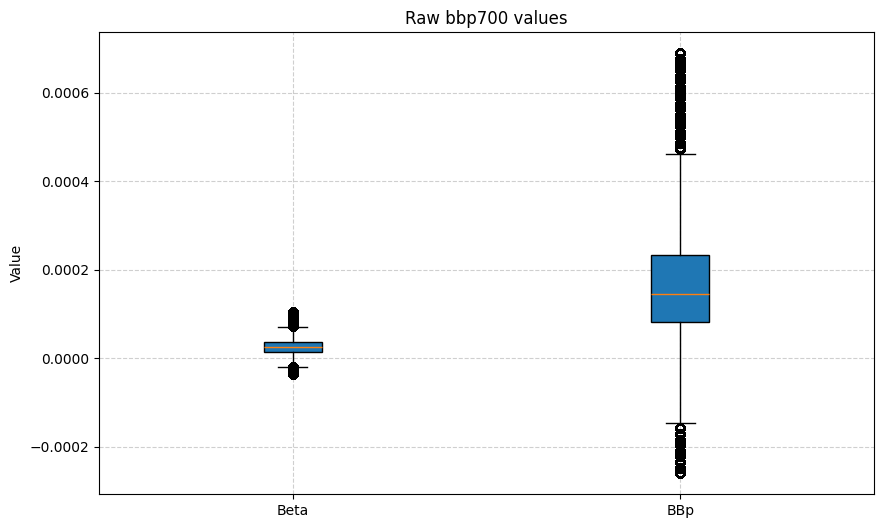

In [7]:
plot_bbp_boxplot(bbp_1d, bbp_corrected, 'Raw bbp700 values')

****

## Positive value [global range]

c:\Users\flapet\OneDrive - NOC\Documents\risc_glider_demo\risc_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


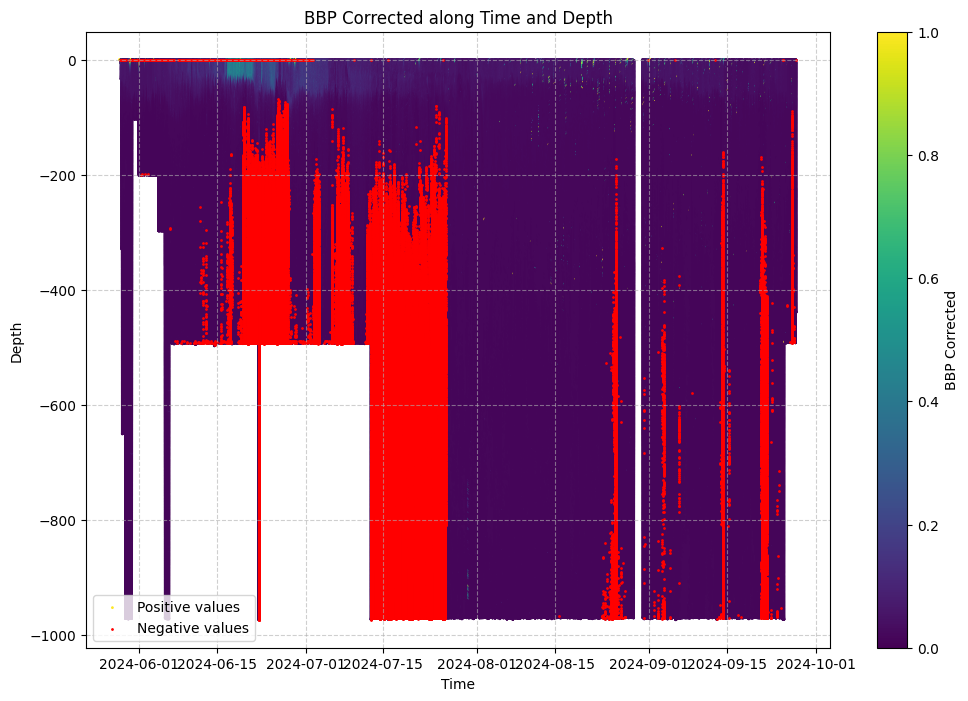

In [8]:
# Mask for negative values
nan_mask = np.isnan(bbp_corrected)
negative_mask = bbp_corrected < 0

# Plot
plt.figure(figsize=(12, 8))
plt.scatter(ds['TIME'].data[~nan_mask], ds['DEPTH_INTERP'].data[~nan_mask],
            c=bbp_corrected[~nan_mask], cmap='viridis', s=1, label='Positive values')
plt.scatter(ds['TIME'].data[negative_mask], ds['DEPTH_INTERP'].data[negative_mask],
            c='red', s=1, label='Negative values')

plt.colorbar(label='BBP Corrected')
plt.xlabel('Time')
plt.ylabel('Depth')
plt.title('BBP Corrected along Time and Depth')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [9]:
def nan_negative_values(data):
    """
    Replace negative values in the data array with NaN, while keeping NaNs unchanged.
    """
    data = np.array(data)
    data[data < 0] = np.nan
    return data

In [10]:
bbp_corrected = nan_negative_values(bbp_corrected)

****

## Spike detection

In [11]:
bbp_baseline, bbp_spikes = gt.cleaning.despike(bbp_corrected, 7, spike_method='minmax')

c:\Users\flapet\OneDrive - NOC\Documents\risc_glider_demo\risc_env\lib\site-packages\glidertools\helpers.py:76: GliderToolsWarning: Primary input variable is not xr.DataArray data type - no metadata to pass on.
  warnings.warn(msg, category=GliderToolsWarning)


Beta valid after cleaning: 697357
BBp valid after cleaning: 669392


C:\Users\flapet\AppData\Local\Temp\ipykernel_20340\2781658684.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([beta_clean, bbp_clean],


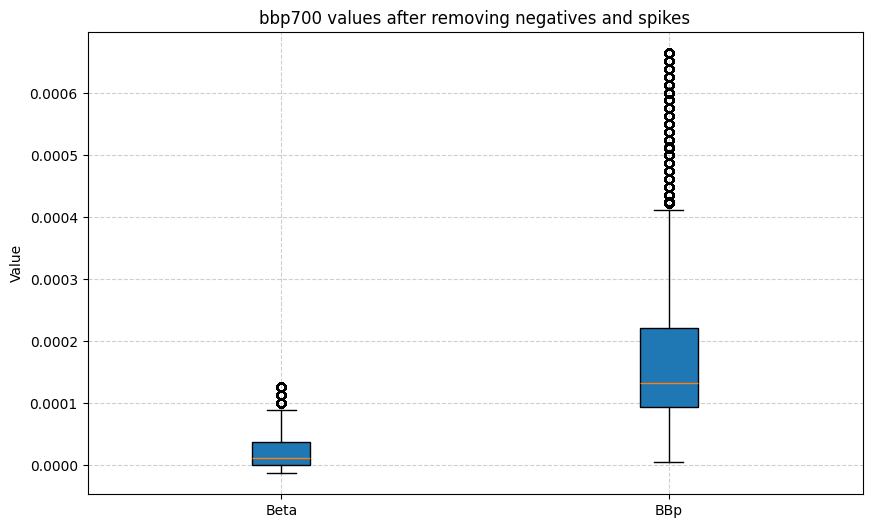

In [13]:
plot_bbp_boxplot(bbp_spikes, bbp_baseline, 'bbp700 values after removing negatives and spikes')

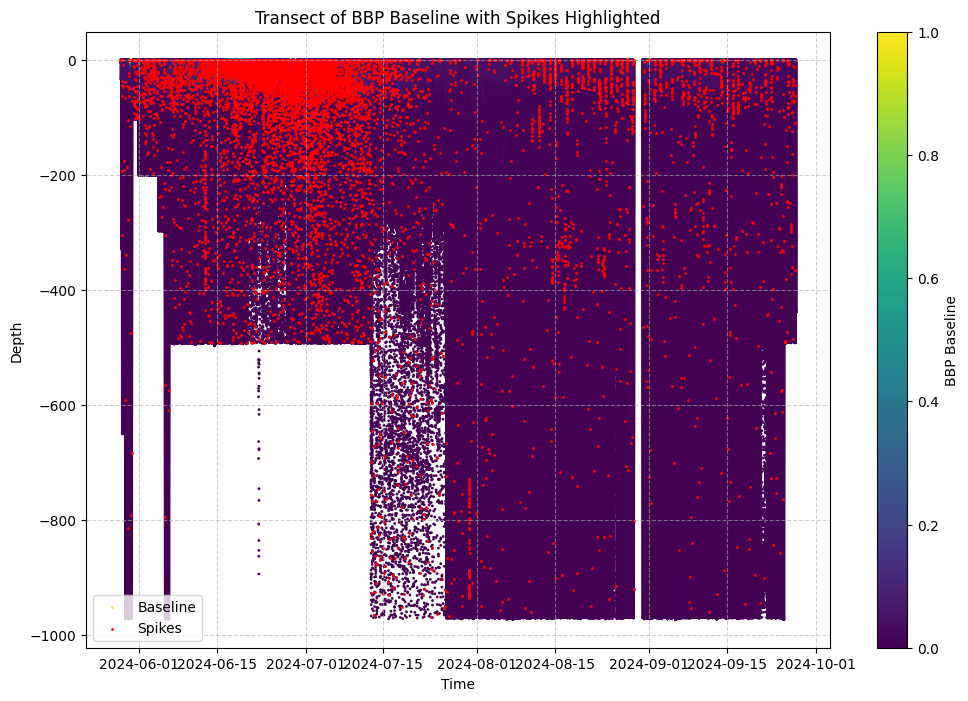

In [16]:
# Plot transect of bbp_baseline with spikes highlighted
plt.figure(figsize=(12, 8))

spikes_mask = bbp_spikes > 0.001

# Plot bbp_baseline
plt.scatter(ds['TIME'].data[~nan_mask], ds['DEPTH_INTERP'].data[~nan_mask],
            c=bbp_baseline[~nan_mask], cmap='viridis', s=1, label='Baseline')

# Overlay spikes in red
plt.scatter(ds['TIME'].data[spikes_mask], ds['DEPTH_INTERP'].data[spikes_mask],
            c='red', s=1, label='Spikes')

plt.colorbar(label='BBP Baseline')
plt.xlabel('Time')
plt.ylabel('Depth')
plt.title('Transect of BBP Baseline with Spikes Highlighted')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

****

## Put data back into the xarray dataset

In [17]:
ds["BBP700_ADJUSTED"] = xr.DataArray(
    bbp_corrected,
    coords={"N_MEASUREMENTS": ds["N_MEASUREMENTS"]},
    dims=ds["BBP700"].dims,
    attrs=ds["BBP700"].attrs
)

ds["BBP700_ADJUSTED"].attrs['long_name'] = 'Corrected particulate backscattering coefficient at 700 nm'
ds["BBP700_ADJUSTED"].attrs['standard_name'] = 'bbp700_adjusted'
ds["BBP700_ADJUSTED"].attrs['comments'] = 'Corrected for temperature and salinity effects, negative values removed'  # TODO interact with config file for window size and method

In [18]:
ds["BBP700_ADJUSTED_baseline"] = xr.DataArray(
    bbp_baseline,
    coords={"N_MEASUREMENTS": ds["N_MEASUREMENTS"]},
    dims=ds["BBP700"].dims,
    attrs=ds["BBP700"].attrs
)

ds["BBP700_ADJUSTED_baseline"].attrs['long_name'] = 'Corrected particulate backscattering coefficient baseline at 700 nm'
ds["BBP700_ADJUSTED_baseline"].attrs['standard_name'] = 'bbp700_adjusted_baseline'
ds["BBP700_ADJUSTED_baseline"].attrs['comments'] = 'Corrected for temperature and salinity effects, negative values removed and spikes removed using min max method with a threshold of 7'  # TODO interact with config file for window size and method

In [19]:
ds["BBP700_ADJUSTED_spikes"] = xr.DataArray(
    bbp_baseline,
    coords={"N_MEASUREMENTS": ds["N_MEASUREMENTS"]},
    dims=ds["BBP700"].dims,
    attrs=ds["BBP700"].attrs
)

ds["BBP700_ADJUSTED_spikes"].attrs['long_name'] = 'Corrected particulate backscattering coefficient spikes at 700 nm'
ds["BBP700_ADJUSTED_spikes"].attrs['standard_name'] = 'bbp700_adjusted_spikes'
ds["BBP700_ADJUSTED_spikes"].attrs['comments'] = 'bbp spikes form min max method with a threshold of 7' 